<a href="https://colab.research.google.com/github/Innoccull/datasets/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=7864be56ea9eab2c56a36af6795b71289150f964b441bcd65d0bfa7347134ae3
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 43.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=e4640c05f9221f676ded588b105fc67751bb7c3bfc664de7c17c9ddc73853a04
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=513235e19427611e474253c6e97ecee48402fa10c373bd4c90f5

In [45]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import imblearn

In [46]:
url = 'https://raw.githubusercontent.com/Innoccull/datasets/main/breast-cancer.csv'

#upload data
data = pd.read_csv(url)

#summary of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [47]:
#encode outcome variable to binary
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

diagnosis = data.loc[:, data.columns == 'diagnosis']
diagnosis = diagnosis.values.ravel()

le.fit(diagnosis)

data['diagnosis'] = le.transform(diagnosis)

In [48]:
#ignore the id variable
data.drop('id', axis=1, inplace=True)

In [49]:
from sklearn.model_selection import train_test_split

#separate predictor and outcome variables for train/test split
X = data.loc[:, data.columns != 'diagnosis']
y = data.loc[:, data.columns == 'diagnosis']

#create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
#load libraries
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

In [51]:
#create objects for pipeline
smt = SMOTE(random_state=42)
ssa = StandardScaler()
umap = UMAP(random_state=456)
svc = SVC(random_state=123)

#create pipeline
svm_pipeline = Pipeline(
    steps=[('smt', smt), ('ssa', ssa), ("umap", umap), ("svc", svc)])

In [52]:
#create tuning grid
params_grid_pipeline = {
    "umap__n_components": [5, 10, 15, 25, 35],
    "svc__C": [10 ** k for k in range(-3, 4)],
}

In [53]:
#create grid search with pipeline
clf_pipeline = GridSearchCV(estimator=svm_pipeline, param_grid=params_grid_pipeline, cv=10, scoring='roc_auc')

#run pipeline
clf_pipeline.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                       ('ssa', StandardScaler()),
                                       ('umap', UMAP(random_state=456)),
                                       ('svc', SVC(random_state=123))]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'umap__n_components': [5, 10, 15, 25, 35]},
             scoring='roc_auc')

# Visualise Crossvalidation Results

We plot mean test score for different cross validation settings to check whether it may be possible to improve performance through expanding the search grid. 

There is a chance that performance could improve Where the mean test performance shows a downward trend at the boundary of the plot.

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

#put results into dataframe for easier posting
cv_results = pd.DataFrame(clf_pipeline.cv_results_)

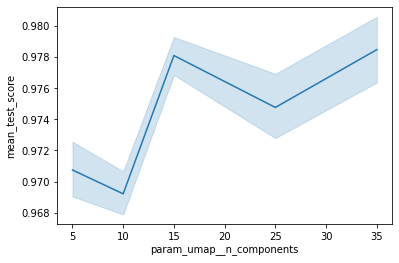

In [55]:
#plot mean test score for number of umap components
sns.lineplot(data = cv_results, y = 'mean_test_score', x = 'param_umap__n_components')

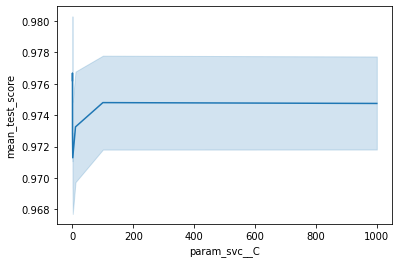

In [56]:
#plot mean test score by C
sns.lineplot(data = cv_results, y = 'mean_test_score', x = 'param_svc__C')

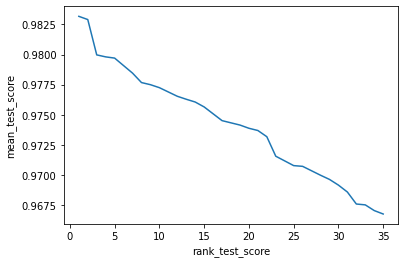

In [57]:
#plot mean test score for all trials
sns.lineplot(data = cv_results, y = 'mean_test_score', x = 'rank_test_score')

# Confusion Matrix

Finally we plot a confusion matrix to show overall performance.

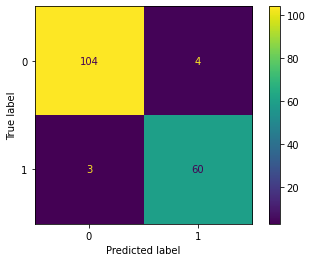

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#get predictiosns on test set
predictions = clf_pipeline.predict(X_test)

#show accuracy

#create confusion matrix
cm = confusion_matrix(y_test, predictions, labels=clf_pipeline.classes_)

#display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_pipeline.classes_)
disp.plot()
plt.show()

Overall accuracy for the model

In [60]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)

accuracy

0.9590643274853801